## Setting Up Your Python Environment

In [1]:
%%capture
# Install PyTorch with CUDA
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install additional dependencies
!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

# # Install package for creating visually distinct colormaps
!pip install distinctipy

# Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

# pycocotools
!pip install pycocotools

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
from copy import copy
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional
import pycocotools

# Import utility functions
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw, ImageFont

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [3]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Directory Paths

In [4]:
# The path for the project folder
project_dir = Path("./")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_path = Path("./dataset/")
# Create the dataset directory if it does not exist

pd.Series({
    "Project Directory:": project_dir, 
    "Dataset Directory:": dataset_path
}).to_frame().style.hide(axis='columns')

Project Directory:,.
Dataset Directory:,dataset


## Loading and Exploring the Dataset

### Getting the Image and Annotation Files

In [5]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Get a list of JSON files in the dataset
annotation_file_path = dataset_path / "annotations.json"

# Load the JSON file
with open(annotation_file_path, "r") as f:
    coco_data = json.load(f)

# Convert to DataFrames
df_annotations = pd.DataFrame(coco_data["annotations"])
df_images = pd.DataFrame(coco_data["images"])
df_categories = pd.DataFrame(coco_data["categories"])

# Rename ID columns for clarity before merging
df_images = df_images.rename(columns={"id": "image_id"})
df_images['file_name'] = df_images.apply(lambda row: str(dataset_path/row['file_name']), axis=1)

df_categories = df_categories.rename(columns={"id": "category_id"})
# In this spesific dataset there no superclasses, and no background class as required by the network, 
# Exploiting that there is an superclass entry for object by setting it to background, and setting superclasses to none
# for other object
df_categories.loc[0, 'name'] = "background"
df_categories = df_categories.assign(supercategory="none")

# Merge annotations with images to get 'file_name'
df_annotations = df_annotations.merge(df_images[["image_id", "file_name"]], on="image_id", how="left")

# Merge annotations with categories to get 'category_name'
df_annotations = df_annotations.merge(df_categories[["category_id", "name"]], on="category_id", how="left")

# Rename 'name' column to 'category_name' for clarity
df_annotations = df_annotations.rename(columns={"name": "category_name"})

df_annotations.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd,file_name,category_name
0,0,0,1,"[163, 179, 305.723, 268.8]",82178.363,"[[197.415, 394.662, 205.292, 404.015, 222.523, 419.769, 250.585, 436.508, 279.138, 444.877, 307.2, 447.831, 348.554, 445.862, 370.215, 442.415, 395.323, 430.108, 420.923, 411.4, 434.708, 396.138, 455.877, 359.215, 462.769, 340.015, 469.169, 308.508, 469.169, 285.369, 459.815, 239.092, 438.154, 197.738, 429.785, 187.4, 420.431, 181, 395.815, 186.415, 367.262, 189.862, 306.051, 192.323, 238.769, 186.908, 225.969, 183.954, 218.585, 179.523, 210.708, 179.031, 191.015, 203.154, 174.769, 234.169, 169.354, 252.385, 163.446, 287.831, 163.938, 314.908, 170.338, 343.462, 178.708, 365.615, 197.415, 394.662]]",0,dataset/8930a436-c9f1-4bc8-adf9-668c5aee446a_jpg.rf.004e04eb8a9cabcad5eeed1b37d66a0c.jpg,fishbowl
1,1,0,2,"[177, 246, 281.108, 200.369]",56325.332,"[[182.154, 357.246, 190.523, 379.4, 200.862, 397.615, 218.092, 415.338, 232.369, 426.169, 251.569, 436.508, 259.446, 438.969, 283.569, 445.369, 323.938, 446.846, 354.954, 443.892, 389.415, 433.062, 410.092, 419.769, 430.277, 400.569, 438.154, 388.754, 451.938, 358.723, 457.846, 305.062, 457.354, 274.538, 453.908, 246.477, 448.492, 248.446, 367.262, 258.785, 320.492, 261.246, 260.431, 259.769, 218.092, 254.354, 197.908, 248.938, 182.646, 247.462, 180.185, 250.908, 179.692, 270.108, 177.231, 282.415, 176.738, 300.631, 178.708, 308.015, 180.185, 347.4, 182.154, 357.246]]",0,dataset/8930a436-c9f1-4bc8-adf9-668c5aee446a_jpg.rf.004e04eb8a9cabcad5eeed1b37d66a0c.jpg,waterlevel
2,2,1,1,"[30, 67, 583.36, 547.2]",319214.592,"[[52.48, 437.76, 60.8, 454.72, 83.84, 492.16, 91.52, 503.04, 107.2, 520.32, 128.32, 540.48, 140.16, 550.08, 186.24, 580.48, 202.56, 588.48, 224.96, 597.44, 252.16, 606.08, 282.56, 611.52, 312.32, 613.76, 340.48, 614.08, 368, 611.52, 394.24, 607.04, 416.96, 600, 453.44, 583.68, 460.8, 577.92, 502.72, 551.04, 525.44, 532.48, 552.32, 503.68, 566.72, 486.08, 583.36, 456.96, 592.32, 438.4, 594.88, 429.76, 599.68, 420.16, 606.08, 397.44, 611.52, 367.04, 613.76, 337.92, 613.44, 309.44, 610.24, 284.16, 602.56, 252.16, 593.6, 227.2, 576.96, 193.28, 550.72, 153.28, 531.52, 130.56, 508.16, 107.52, 507.2, 104.96, 507.52, 96, 513.92, 87.68, 516.48, 81.6, 513.92, 73.92, 510.4, 71.04, 502.72, 71.36, 489.92, 80.32, 485.12, 82.24, 437.44, 89.6, 385.92, 94.4, 312.96, 94.72, ...]]",0,dataset/92ec4612-83cb-446d-8aa3-6e2c2cbd03e4_jpg.rf.1e13f0aef7a8a8b19f691d71767f44fa.jpg,fishbowl
3,3,2,2,"[64, 194, 512.661, 337.364]",172953.709,"[[157.106, 511.509, 183.566, 523.085, 274.522, 531.354, 373.747, 531.354, 468.01, 519.778, 492.817, 504.894, 535.814, 455.282, 560.62, 405.669, 577.158, 346.134, 577.158, 270.062, 567.235, 230.372, 550.698, 195.643, 343.979, 202.258, 97.571, 193.99, 81.034, 208.873, 64.496, 266.755, 64.496, 354.403, 87.649, 423.86, 127.339, 483.395, 157.106, 511.509]]",0,dataset/e89e3304-3030-40c1-9be8-b67df340bbe9_jpg.rf.0a7edc1cfa1311748b37bb9c1332c07e.jpg,waterlevel
4,4,2,1,"[56, 95, 527.545, 438.243]",231192.944,"[[97.571, 447.013, 155.452, 513.163, 171.99, 523.085, 203.411, 529.7, 370.439, 533.008, 469.664, 521.432, 491.163, 508.202, 542.429, 450.32, 567.235, 402.362, 582.119, 349.442, 583.773, 271.716, 560.62, 197.297, 535.814, 152.646, 499.432, 112.956, 497.778, 104.687, 472.972, 96.419, 205.065, 94.765, 145.53, 103.034, 89.302, 174.145, 64.496, 238.641, 57.881, 276.677, 56.227, 316.367, 62.842, 361.018, 79.38, 412.284, 97.571, 447.013]]",0,dataset/e89e3304-3030-40c1-9be8-b67df340bbe9_jpg.rf.0a7edc1cfa1311748b37bb9c1332c07e.jpg,fishbowl


### Get Image File Paths

In [6]:
# Create a dictionary mapping image_id to its annotations
annotations_by_image = df_annotations.groupby("image_id").apply(lambda x: x.to_dict(orient="records")).to_dict()

# Example: Get annotations for a specific image_id (replace with an actual ID from image_ids)
example_image_id = df_images["image_id"][0]
annotations_for_image = df_annotations[df_annotations["image_id"] == example_image_id]
annotations_for_image = [row for _, row in annotations_for_image.iterrows()]

# Print results
print(f"Image ID: {example_image_id}")
for anno in annotations_for_image:
    print(anno['bbox'])
    print(anno['category_name'])
# Print the number of image files
print(f"Number of Images: {len(df_images)}")

Image ID: 0
[163, 179, 305.723, 268.8]
fishbowl
[177, 246, 281.108, 200.369]
waterlevel
Number of Images: 96


### Get Image Annotations

### Inspecting the Class Distribution

#### Get image classes

In [7]:
# Get a list of unique labels in the 'annotation_df' DataFrame
#class_names = shapes_df['label'].unique().tolist()

class_names = df_annotations['category_name'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,fishbowl
1,waterlevel


#### Visualize the class distribution

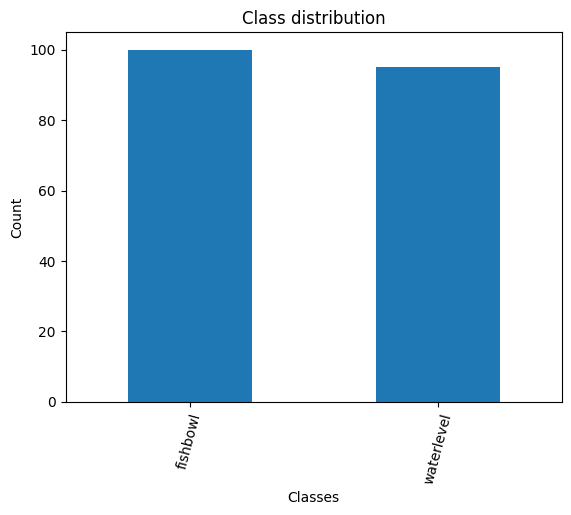

In [8]:
# Get the number of samples for each object class
class_counts = df_annotations['category_name'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names, rotation=75)  # Set the x-axis tick labels
plt.show()

#### Add a background class

In [9]:
# Prepend a `background` class to the list of class names
class_names = ['background']+class_names

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,background
1,fishbowl
2,waterlevel


### Visualizing Image Annotations

#### Generate a color map

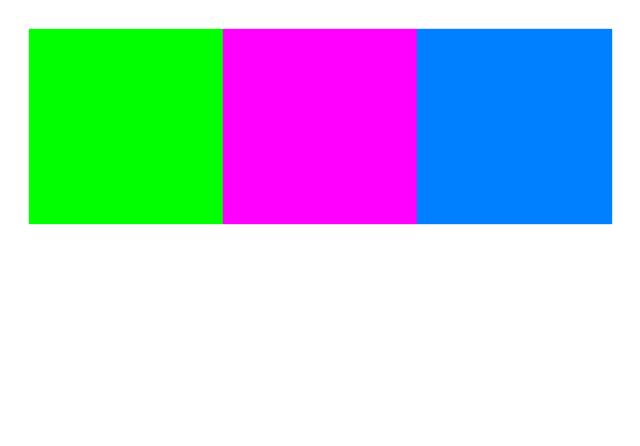

In [10]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Define the bounding box annotation function

In [11]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=None)

### Selecting a Sample Image

In [12]:
img_rec = df_images.loc[0]
file_name = img_rec.loc["file_name"]
file_id = img_rec.loc["image_id"]

#### Load the sample image

Image Dims: (640, 640)


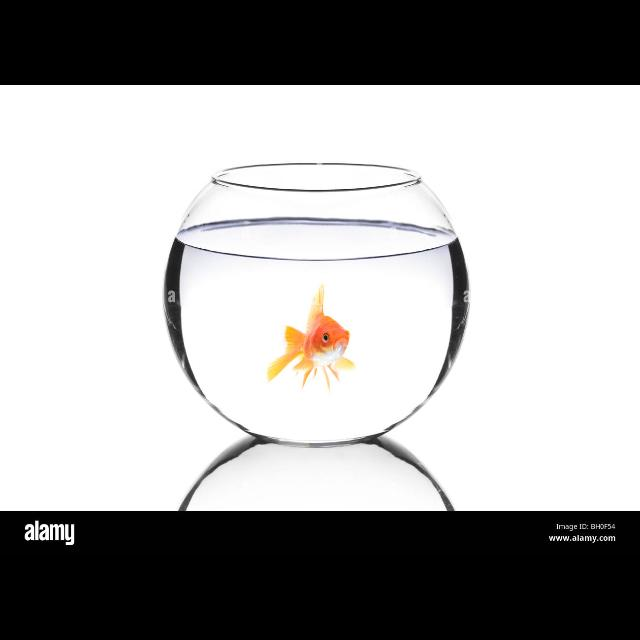

In [13]:
# Get the file ID of the first image file

# Open the associated image file as a RGB image
sample_img = Image.open(file_name).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [14]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
df_annotations[df_annotations["image_id"]==file_id]

,id,image_id,category_id,bbox,area,segmentation,iscrowd,file_name,category_name
0,0,0,1,"[163, 179, 305.723, 268.8]",82178.363,"[[197.415, 394.662, 205.292, 404.015, 222.523, 419.769, 250.585, 436.508, 279.138, 444.877, 307.2, 447.831, 348.554, 445.862, 370.215, 442.415, 395.323, 430.108, 420.923, 411.4, 434.708, 396.138, 455.877, 359.215, 462.769, 340.015, 469.169, 308.508, 469.169, 285.369, 459.815, 239.092, 438.154, 197.738, 429.785, 187.4, 420.431, 181, 395.815, 186.415, 367.262, 189.862, 306.051, 192.323, 238.769, 186.908, 225.969, 183.954, 218.585, 179.523, 210.708, 179.031, 191.015, 203.154, 174.769, 234.169, 169.354, 252.385, 163.446, 287.831, 163.938, 314.908, 170.338, 343.462, 178.708, 365.615, 197.415, 394.662]]",0,dataset/8930a436-c9f1-4bc8-adf9-668c5aee446a_jpg.rf.004e04eb8a9cabcad5eeed1b37d66a0c.jpg,fishbowl
1,1,0,2,"[177, 246, 281.108, 200.369]",56325.332,"[[182.154, 357.246, 190.523, 379.4, 200.862, 397.615, 218.092, 415.338, 232.369, 426.169, 251.569, 436.508, 259.446, 438.969, 283.569, 445.369, 323.938, 446.846, 354.954, 443.892, 389.415, 433.062, 410.092, 419.769, 430.277, 400.569, 438.154, 388.754, 451.938, 358.723, 457.846, 305.062, 457.354, 274.538, 453.908, 246.477, 448.492, 248.446, 367.262, 258.785, 320.492, 261.246, 260.431, 259.769, 218.092, 254.354, 197.908, 248.938, 182.646, 247.462, 180.185, 250.908, 179.692, 270.108, 177.231, 282.415, 176.738, 300.631, 178.708, 308.015, 180.185, 347.4, 182.154, 357.246]]",0,dataset/8930a436-c9f1-4bc8-adf9-668c5aee446a_jpg.rf.004e04eb8a9cabcad5eeed1b37d66a0c.jpg,waterlevel


#### Define a function to convert segmentation polygons to images

In [15]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

#### Annotate sample image

[[[197.415, 394.662, 205.292, 404.015, 222.523, 419.769, 250.585, 436.508, 279.138, 444.877, 307.2, 447.831, 348.554, 445.862, 370.215, 442.415, 395.323, 430.108, 420.923, 411.4, 434.708, 396.138, 455.877, 359.215, 462.769, 340.015, 469.169, 308.508, 469.169, 285.369, 459.815, 239.092, 438.154, 197.738, 429.785, 187.4, 420.431, 181, 395.815, 186.415, 367.262, 189.862, 306.051, 192.323, 238.769, 186.908, 225.969, 183.954, 218.585, 179.523, 210.708, 179.031, 191.015, 203.154, 174.769, 234.169, 169.354, 252.385, 163.446, 287.831, 163.938, 314.908, 170.338, 343.462, 178.708, 365.615, 197.415, 394.662]], [[182.154, 357.246, 190.523, 379.4, 200.862, 397.615, 218.092, 415.338, 232.369, 426.169, 251.569, 436.508, 259.446, 438.969, 283.569, 445.369, 323.938, 446.846, 354.954, 443.892, 389.415, 433.062, 410.092, 419.769, 430.277, 400.569, 438.154, 388.754, 451.938, 358.723, 457.846, 305.062, 457.354, 274.538, 453.908, 246.477, 448.492, 248.446, 367.262, 258.785, 320.492, 261.246, 260.431, 259.76

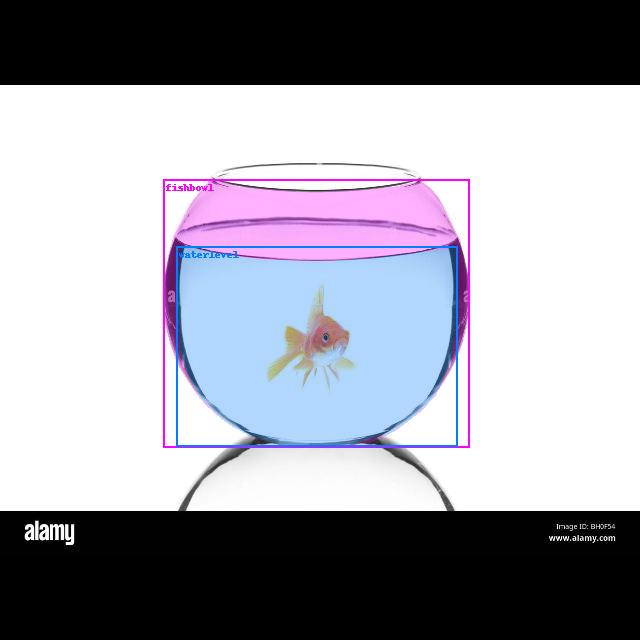

In [16]:
# Extract the labels for the sample
df_sample_annotations = df_annotations[df_annotations["image_id"] == file_id]
labels = df_sample_annotations['category_name'].tolist()
# Extract the polygon points for segmentation mask
segmentations = df_sample_annotations['segmentation'].tolist()
# Format polygon points for PIL
print(segmentations)
xy_coords = [[tuple((points[0][i],points[0][i+1])) for i in range(0, len(points[0]), 2)] for points in segmentations]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=bboxes, 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Loading the Mask R-CNN Model

### Setting the Device and Data Type

In [17]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

In [18]:
# Initialize a Mask R-CNN model with pretrained weights
class CustomMaskRCNN(MaskRCNN):
    def __init__(self, num_classes=91, weights='DEFAULT'):
        # Get the customized model from torchvision
        base_model = maskrcnn_resnet50_fpn_v2(weights=weights)
        
        # Extract the backbone (already customized)
        backbone = base_model.backbone

        # Extract other arguments from the existing model
        rpn = base_model.rpn
        roi_heads = base_model.roi_heads
        transform = base_model.transform

        # Call MaskRCNN constructor with extracted components
        super().__init__(backbone, num_classes=num_classes,
                         rpn=rpn, roi_heads=roi_heads, transform=transform)

        # Example: Modify something in the child class
        self.roi_heads.box_predictor = FastRCNNPredictor(
            in_channels=self.roi_heads.box_predictor.cls_score.in_features, 
            num_classes=num_classes
        )

        # Replace the mask predictor
        self.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_channels=self.roi_heads.mask_predictor.conv5_mask.in_channels, 
            dim_reduced=self.roi_heads.mask_predictor.conv5_mask.out_channels, 
            num_classes=num_classes
        )

num_classes = len(class_names)

# load model
model = CustomMaskRCNN(num_classes=num_classes)

# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

### Summarizing the Model

In [19]:
test_inp = torch.randn(1, 3, 256, 256).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/home/hallvard/anaconda3/envs/dvc/lib/python3.11/site-packages/torchtnt/utils/module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,CustomMaskRCNN,44.0 M,43.8 M,176 M,185 G


## Preparing the Data

### Training-Validation Split

In [20]:
train_ratio = 0.85

# Shuffle the dataset
df_images = df_images.sample(frac=1, random_state=42).reset_index(drop=True)

# Compute split index
split_idx = int(len(df_images) * train_ratio)

# Split into train and validation sets
df_train = df_images.iloc[:split_idx].reset_index(drop=True)
df_val = df_images.iloc[split_idx:].reset_index(drop=True)

# Split annotations based on image_id
df_train_annotations = df_annotations[df_annotations["image_id"].isin(df_train["image_id"])]
df_val_annotations = df_annotations[df_annotations["image_id"].isin(df_val["image_id"])]

pd.Series({
    "Training Samples:": len(df_train),
    "Training Anno Samples:": len(df_train_annotations),
    "Validation Samples:": len(df_val),
    "Validation Anno Samples:": len(df_val_annotations),
}).to_frame().style.hide(axis='columns')

Training Samples:,81
Training Anno Samples:,164
Validation Samples:,15
Validation Anno Samples:,31


### Data Augmentation

#### Set training image size

In [21]:
# Set training image size
train_sz = 512

#### Initialize the transforms

In [22]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

In [23]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

[[[197.415, 394.662, 205.292, 404.015, 222.523, 419.769, 250.585, 436.508, 279.138, 444.877, 307.2, 447.831, 348.554, 445.862, 370.215, 442.415, 395.323, 430.108, 420.923, 411.4, 434.708, 396.138, 455.877, 359.215, 462.769, 340.015, 469.169, 308.508, 469.169, 285.369, 459.815, 239.092, 438.154, 197.738, 429.785, 187.4, 420.431, 181, 395.815, 186.415, 367.262, 189.862, 306.051, 192.323, 238.769, 186.908, 225.969, 183.954, 218.585, 179.523, 210.708, 179.031, 191.015, 203.154, 174.769, 234.169, 169.354, 252.385, 163.446, 287.831, 163.938, 314.908, 170.338, 343.462, 178.708, 365.615, 197.415, 394.662]], [[182.154, 357.246, 190.523, 379.4, 200.862, 397.615, 218.092, 415.338, 232.369, 426.169, 251.569, 436.508, 259.446, 438.969, 283.569, 445.369, 323.938, 446.846, 354.954, 443.892, 389.415, 433.062, 410.092, 419.769, 430.277, 400.569, 438.154, 388.754, 451.938, 358.723, 457.846, 305.062, 457.354, 274.538, 453.908, 246.477, 448.492, 248.446, 367.262, 258.785, 320.492, 261.246, 260.431, 259.76

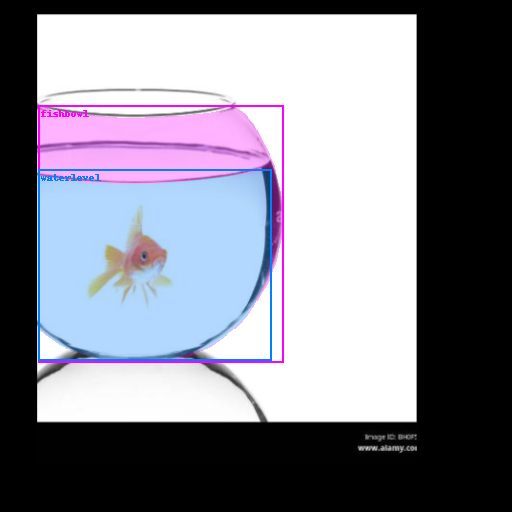

Source Image:,"(640, 640)"
Cropped Image:,"(396, 535)"
Resized Image:,"(378, 510)"
Padded Image:,"(510, 510)"
Resized Padded Image:,"(512, 512)"


In [24]:
# Extract the labels for the sample
df_sample_annotations = df_annotations[df_annotations["image_id"] == file_id]
labels = df_sample_annotations['category_name'].tolist()
# Extract the polygon points for segmentation mask
segmentations = df_sample_annotations['segmentation'].tolist()
# Format polygon points for PIL
print(segmentations)
xy_coords = [[tuple((points[0][i],points[0][i+1])) for i in range(0, len(points[0]), 2)] for points in segmentations]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])


# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare mask and bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': bboxes, 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}


# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)


# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)

# print targets at current stage
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)


# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=torchvision.ops.masks_to_boxes(targets['masks']), 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=sample_colors
)

# # Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [25]:
class FishbowlDataset(Dataset):
    """
    This class represents a PyTorch Dataset for a collection of images and their annotations.
    The class is designed to load images along with their corresponding segmentation masks, bounding box annotations, and labels.
    """
    def __init__(self, df_images, df_annotations, transforms=None):
        """
        Constructor for the HagridDataset class.

        Parameters:
        img_keys (list): List of unique identifiers for images.
        annotation_df (DataFrame): DataFrame containing the image annotations.
        img_dict (dict): Dictionary mapping image identifiers to image file paths.
        class_to_idx (dict): Dictionary mapping class labels to indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._df_images = df_images  # List of image keys
        self._df_annotations = df_annotations  # DataFrame containing annotations
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        int: The number of items in the dataset.
        """
        return len(self._df_images)
        
    def __getitem__(self, index):
        """
        Fetch an item from the dataset at the specified index.

        Parameters:
        index (int): Index of the item to fetch from the dataset.

        Returns:
        tuple: A tuple containing the image and its associated target (annotations).
        """
        # Load the image and its target (segmentation masks, bounding boxes and labels)
        image, target = self._load_image_and_target(index)
        
        # Apply the transformations, if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, index):
        """
        Load an image and its target (bounding boxes and labels).

        Parameters:
        annotation (pandas.Series): The annotations for an image.

        Returns:
        tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels' keys.
        """

        img_rec = self._df_images.loc[index]
        file_name = img_rec.loc["file_name"]
        file_id = img_rec.loc["image_id"]

        # Retrieve the file path of the image
        filepath = file_name
        # Open the image file and convert it to RGB
        image = Image.open(filepath).convert('RGB')
        
        annotations = self._df_annotations[self._df_annotations["image_id"] == file_id]
        # Extract the labels for the sample
        labels = annotations['category_id'].tolist()
        labels = torch.Tensor(labels)
        labels = labels.to(dtype=torch.int64)
        # Extract the polygon points for segmentation mask
        segmentations = annotations['segmentation'].tolist()
        # Format polygon points for PIL
        xy_coords = [[tuple((points[0][i],points[0][i+1])) for i in range(0, len(points[0]), 2)] for points in segmentations]
        # Generate mask images from polygons
        mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))
        
        # Generate bounding box annotations from segmentation masks
        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])
                
        return image, {'masks': masks,'boxes': bboxes, 'labels': labels}

### Image Transforms

In [26]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [27]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
train_dataset = FishbowlDataset(df_train, df_train_annotations, train_tfms)
valid_dataset = FishbowlDataset(df_val, df_val_annotations, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,81
Validation dataset size:,15


### Inspect Samples

#### Inspect training set sample

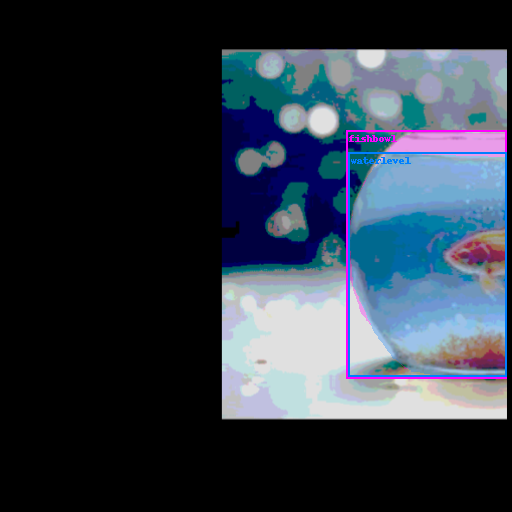

In [28]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

#### Inspect validation set sample

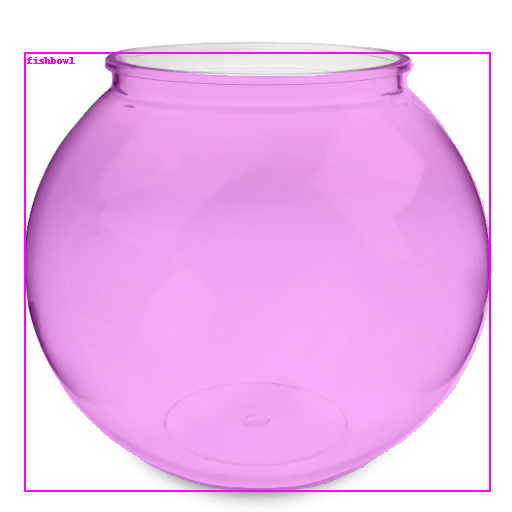

In [29]:
dataset_sample = valid_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [30]:
# Set the training batch size
bs = 4

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn': lambda batch: tuple(zip(*batch)),
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,21
Number of batches in validation DataLoader:,4


## Fine-tuning the Model

### Define the Training Loop

In [31]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    """
    Function to run a single training or evaluation epoch.
    
    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.
    
    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode
    model.train()
    
    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar
    
    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)
        
        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))
        
            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item
        
        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    # Cleanup and close the progress bar 
    progress_bar.close()
    
    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer,  
               lr_scheduler, 
               device, 
               epochs, 
               checkpoint_path, 
               use_scaler=False):
    """
    Main training loop.
    
    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device
    
    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [32]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

2025-03-09_12-46-24/maskrcnn_resnet50_fpn_v2.pth


### Save the Color Map

In [33]:
# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

2025-03-09_12-46-24/dataset-colormap.json


### Configure the Training Parameters

In [34]:
# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 40

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

### Train the Model

In [35]:
train_loop(model=model, 
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer, 
           lr_scheduler=lr_scheduler, 
           device=torch.device(device), 
           epochs=epochs, 
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

## Making Predictions with the Model

### Preparing Input Data

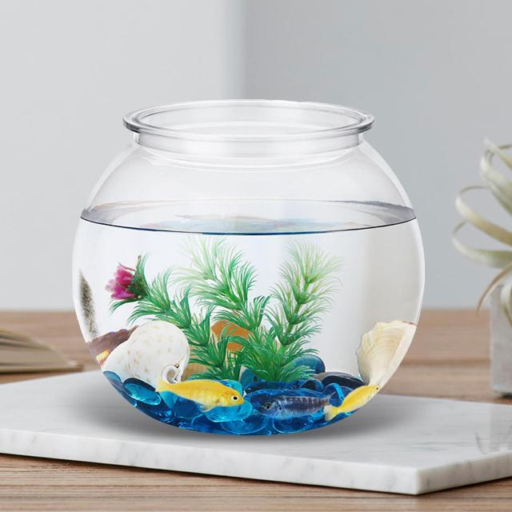

Source Image Size:,"(512, 512)"
Input Dims:,"(512, 512)"
Min Image Scale:,1.000000
Input Image Size:,"(512, 512)"


In [36]:
# Choose a random item from the validation set
index = random.randint(0, len(valid_dataset)-1)

dataset_sample = valid_dataset[index]

# Annotate the sample image with segmentation masks
test_img = tensor_to_pil((dataset_sample[0]*255).to(dtype=torch.uint8))

# Resize the test image
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

#### Get the target annotation data

#### Pass the input data to the model

In [46]:
checkpoint_path = '2025-03-09_12-29-05/maskrcnn_resnet50_fpn_v2.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
inference_model = CustomMaskRCNN(num_classes=num_classes)
inference_model.load_state_dict(checkpoint)
# Set the model to evaluation mode
inference_model.eval();

# Ensure the model and input data are on the same device
inference_model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = inference_model(input_tensor)

#### Filter the model output

In [39]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold

# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']

# Scale and stack the predicted segmentation masks
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

#### Annotate the image using the model predictions 

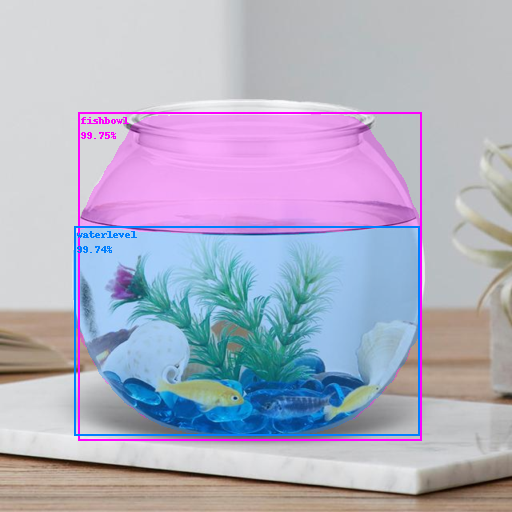

In [40]:
# Get the annotation colors for the targets and predictions
#target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

# Convert the test images to a tensor
img_tensor = transforms.PILToTensor()(test_img)

# Annotate the test image with the target segmentation masks
#annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
# Annotate the test image with the target bounding boxes
#annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
# Display the annotated test image
#annotated_test_img = tensor_to_pil(annotated_tensor)

# Annotate the test image with the predicted segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
# Annotate the test image with the predicted labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=pred_bboxes, 
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

display(tensor_to_pil(annotated_tensor))

# Display the annotated test image with the predicted bounding boxes
#display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

# Print the prediction data as a Pandas DataFrame for easy formatting
#pd.Series({
#    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
#    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
#    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
#}).to_frame().style.hide(axis='columns')

In [55]:
dummy_input = torch.randn(1, 3, 512, 512, device="cpu")
inference_model.to("cpu")
onnx_path = checkpoint_path.replace(".pth", ".onnx")

onnx_program = torch.onnx.export(
    inference_model,
    dummy_input,
    onnx_path,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["boxes", "labels", "scores", "masks"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "height", 3: "width"},
        "boxes": {0: "num_boxes"},
        "labels": {0: "num_boxes"},
        "scores": {0: "num_boxes"},
        "masks": {0: "num_boxes", 1: "channels", 2: "height", 3: "width"},
    },
)